In [29]:
pip install medmnist torch torchvision matplotlib seaborn scikit-learn umap-learn xgboost statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 8.5 MB/s eta 0:00:00 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd

# Load the npz file directly
data = np.load('pathmnist.npz')

# Combine all splits
all_images = np.concatenate([
    data['train_images'],
    data['val_images'],
    data['test_images']
], axis=0)

all_labels = np.concatenate([
    data['train_labels'],
    data['val_labels'],
    data['test_labels']
], axis=0).flatten()

# Flatten each image from (28, 28, 3) → 1D vector
flat_images = all_images.reshape((all_images.shape[0], -1))

# Create DataFrame: first column is label, rest are pixels
df_full = pd.DataFrame(flat_images)
df_full.insert(0, "label", all_labels)

# Preview
print(df_full.head())

# Optional: Save to CSV
df_full.to_csv("pathmnist_full_dataset.csv", index=False)

   label      0      1      2      3      4      5      6      7      8  ...  \
0    0.0  220.0  208.0  227.0  219.0  207.0  227.0  220.0  207.0  227.0  ...   
1    4.0  126.0   59.0  119.0  142.0   84.0  139.0  174.0  127.0  176.0  ...   
2    7.0  223.0  168.0  204.0  223.0  166.0  203.0  218.0  170.0  205.0  ...   
3    5.0  216.0  135.0  183.0  216.0  127.0  178.0  213.0  125.0  175.0  ...   
4    5.0  204.0  124.0  177.0  204.0  116.0  170.0  211.0  149.0  190.0  ...   

    2342   2343   2344   2345   2346   2347   2348   2349   2350   2351  
0  227.0  220.0  208.0  227.0  221.0  208.0  227.0  222.0  209.0  228.0  
1  211.0  185.0  150.0  193.0  168.0  126.0  177.0  177.0  137.0  184.0  
2  178.0  220.0  163.0  200.0  223.0  159.0  199.0  223.0  155.0  196.0  
3  188.0  212.0  130.0  178.0  214.0  129.0  178.0  218.0  133.0  181.0  
4  180.0  194.0  124.0  176.0  217.0  170.0  205.0  229.0  206.0  225.0  

[5 rows x 2353 columns]


In [ ]:
# Step 1: Define the mapping from label numbers to medical class names
label_map = {
    0: 'ADI',
    1: 'BACK',
    2: 'DEB',
    3: 'LYM',
    4: 'MUC',
    5: 'MUS',
    6: 'NORM',
    7: 'STR',
    8: 'TUM'
}

# Step 2: Apply stratified sampling (4500 rows per class)
df_sampled = df_full.groupby('label').apply(lambda x: x.sample(n=4500, random_state=42)).reset_index(drop=True)

# Step 3: Replace numeric labels with string labels using the mapping
df_sampled['label'] = df_sampled['label'].map(label_map)

# Save to CSV
df_sampled.to_csv("pathmnist_stratified_4500_per_class_labeled.csv", index=False)

# Confirm shape
print(df_sampled.shape)

/var/folders/sy/hms76h_s3393m0hc_w8sjrvh0000gn/T/ipykernel_45500/31134318.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_full.groupby('label').apply(lambda x: x.sample(n=4500, random_state=42)).reset_index(drop=True)


(40500, 2353)


In [ ]:
# Step 4: Check and drop missing values
missing_before = df_sampled.isnull().sum().sum()
df_sampled = df_sampled.dropna()
missing_after = df_sampled.isnull().sum().sum()

# Step 5: Check and drop duplicate rows
duplicates_before = df_sampled.duplicated().sum()
df_sampled = df_sampled.drop_duplicates()
duplicates_after = df_sampled.duplicated().sum()

# Save cleaned dataset again
df_sampled.to_csv("pathmnist_balanced_labeled_cleaned.csv", index=False)

# Print summary
print(f"Missing values removed: {missing_before - missing_after}")
print(f"Duplicate rows removed: {duplicates_before - duplicates_after}")
print(f"Final shape: {df_sampled.shape}")


Missing values removed: 0
Duplicate rows removed: 0
Final shape: (40500, 2353)


In [ ]:
# Step 6: One-hot encode the label column and keep the original label
if 'label' in df_sampled.columns:
    df_encoded = pd.get_dummies(df_sampled, columns=['label'])
    df_encoded['label'] = df_sampled['label']  # reattach the original label
else:
    print("Error: 'label' column not found in df_sampled.")

# Save the final one-hot encoded dataset
df_encoded.to_csv("pathmnist_preprocessed_final.csv", index=False)

# Confirmation message
print(f"\n✅ Final one-hot encoded dataset saved as 'pathmnist_preprocessed_final.csv'.")
print(f"Final DataFrame shape: {df_encoded.shape}")


✅ Final one-hot encoded dataset saved as 'pathmnist_preprocessed_final.csv'.
Final DataFrame shape: (40500, 2362)


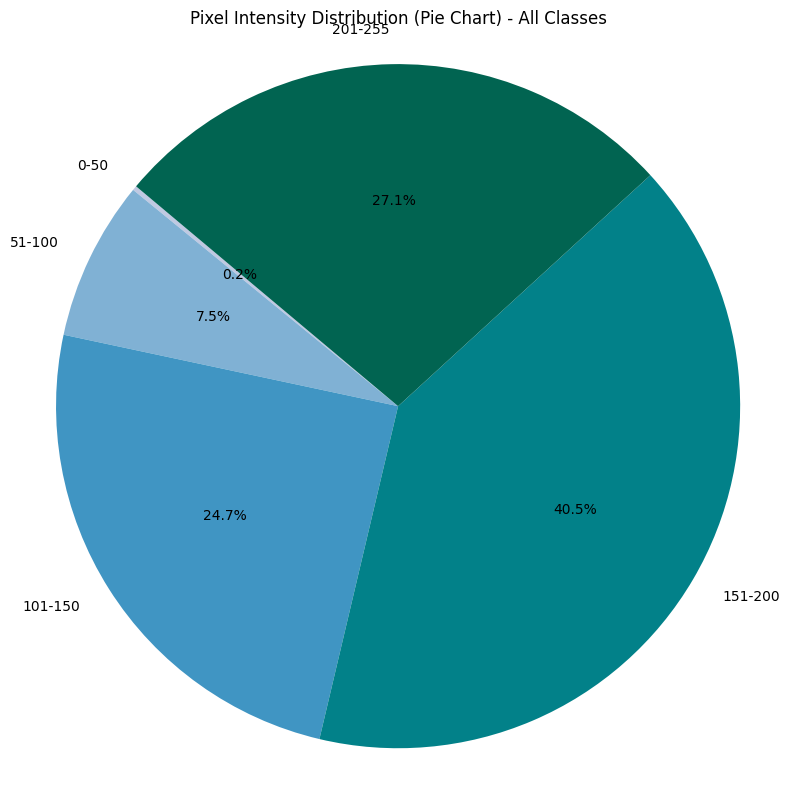

In [21]:
import matplotlib.pyplot as plt

# Ensure 'label' is excluded and only pixel columns are included
pixel_columns = df_sampled.columns.difference(['label', 'MeanIntensity'])  # MeanIntensity might exist
pixels = df_sampled[pixel_columns].values.flatten()

# Define intensity bins and labels
bins = [0, 50, 100, 150, 200, 255]
labels = ['0-50', '51-100', '101-150', '151-200', '201-255']

# Bin the pixel values
binned = pd.cut(pixels, bins=bins, labels=labels, include_lowest=True)

# Count pixels in each bin
intensity_counts = binned.value_counts().sort_index()

# Generate colors
cmap = plt.cm.PuBuGn
colors = [cmap(i) for i in np.linspace(0.3, 0.9, len(labels))]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(intensity_counts, labels=intensity_counts.index, autopct='%1.1f%%',
        startangle=140, colors=colors)
plt.title("Pixel Intensity Distribution (Pie Chart) - All Classes")
plt.axis('equal')
plt.tight_layout()
plt.show()


In [23]:
# Exclude label and MeanIntensity columns
pixel_columns = df_sampled.columns.difference(['label', 'MeanIntensity'])

# Flatten all pixel values into a single array
pixel_values = df_sampled[pixel_columns].values.flatten()

# Get the minimum and maximum pixel intensity values
min_value = pixel_values.min()
max_value = pixel_values.max()

print(f"Range of pixel intensity values: {min_value} to {max_value}")


Range of pixel intensity values: 0.0 to 255.0


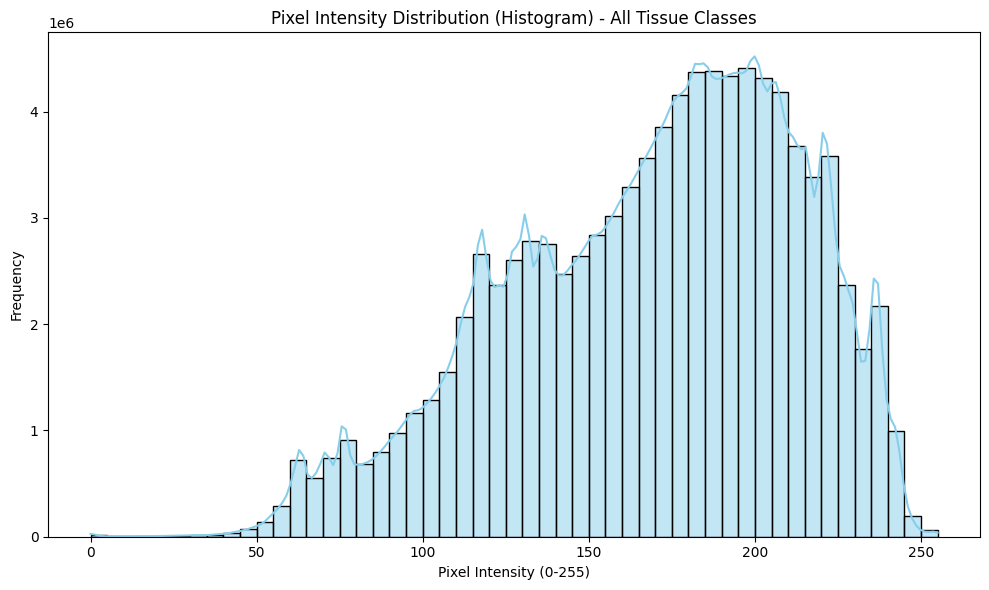

In [22]:
import seaborn as sns

# Exclude label and optional MeanIntensity columns to get pixel data only
pixel_columns = df_sampled.columns.difference(['label', 'MeanIntensity'])
pixels = df_sampled[pixel_columns].values.flatten()

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(pixels, bins=51, kde=True, color='skyblue', edgecolor='black')
plt.title('Pixel Intensity Distribution (Histogram) - All Tissue Classes')
plt.xlabel('Pixel Intensity (0-255)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


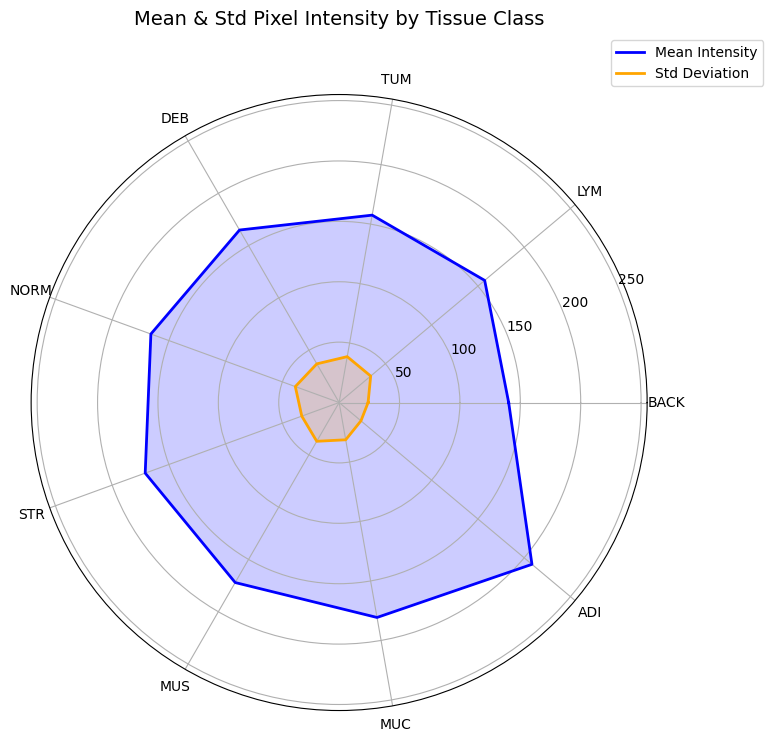

  label  mean_intensity  std_intensity
1  BACK      140.360587      23.968764
3   LYM      157.299451      34.097905
8   TUM      157.541438      38.569256
2   DEB      164.916827      36.965259
6  NORM      165.855119      38.601943
7   STR      170.868138      32.914617
5   MUS      172.092981      37.058269
4   MUC      180.697057      31.321602
0   ADI      208.395545      23.585555


In [24]:
from math import pi

# Select pixel-only columns (exclude label and MeanIntensity)
pixel_columns = df_sampled.columns.difference(['label', 'MeanIntensity'])

# Calculate mean and std pixel intensity per image
df_sampled['mean_intensity'] = df_sampled[pixel_columns].mean(axis=1)
df_sampled['std_intensity'] = df_sampled[pixel_columns].std(axis=1)

# Group by tissue class and calculate mean across samples
grouped = df_sampled.groupby('label').agg({
    'mean_intensity': 'mean',
    'std_intensity': 'mean'
}).reset_index()

# Sort by mean to improve circular plot layout
grouped = grouped.sort_values(by='mean_intensity')

# Extract values
labels = grouped['label'].tolist()
mean_values = grouped['mean_intensity'].tolist()
std_values = grouped['std_intensity'].tolist()

# Create angles for radar chart
angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]

# Complete the loop for closed radar plot
labels += [labels[0]]
mean_values += [mean_values[0]]
std_values += [std_values[0]]
angles += [angles[0]]

# Plot radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.set_ylim(0, 255)

# Plot mean
ax.plot(angles, mean_values, linewidth=2, label='Mean Intensity', color='blue')
ax.fill(angles, mean_values, alpha=0.2, color='blue')

# Plot std deviation
ax.plot(angles, std_values, linewidth=2, label='Std Deviation', color='orange')
ax.fill(angles, std_values, alpha=0.2, color='orange')

# Ticks and labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels[:-1], fontsize=10)
ax.set_title("Mean & Std Pixel Intensity by Tissue Class", size=14, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.show()

# Optional: Check for any sharp differences
print(grouped[['label', 'mean_intensity', 'std_intensity']])


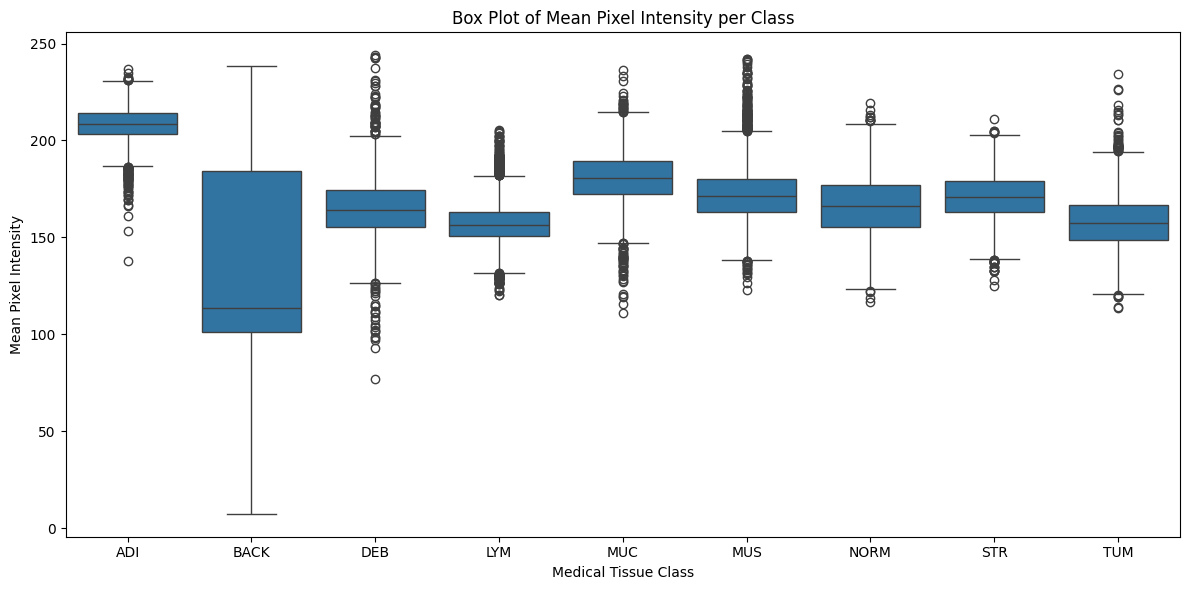

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate mean intensity from all pixel columns
pixel_columns = df_sampled.columns.difference(['label'])
df_sampled['MeanIntensity'] = df_sampled[pixel_columns].mean(axis=1)

# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='MeanIntensity', data=df_sampled)
plt.title("Box Plot of Mean Pixel Intensity per Class")
plt.xlabel("Medical Tissue Class")
plt.ylabel("Mean Pixel Intensity")
plt.tight_layout()
plt.show()

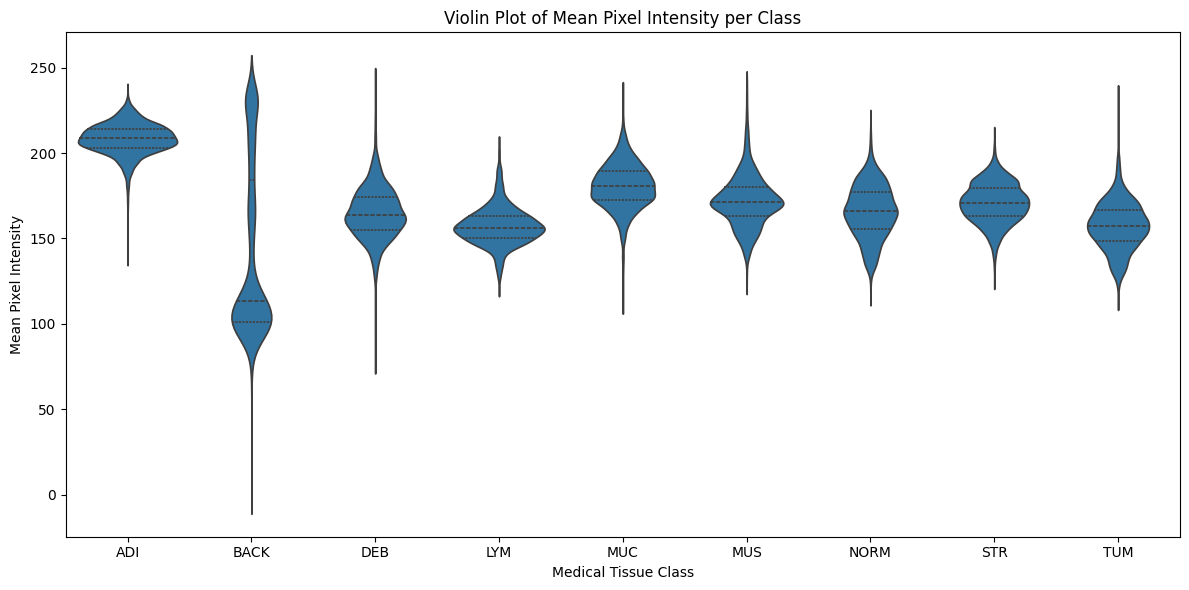

In [11]:
# Violin Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='label', y='MeanIntensity', data=df_sampled, inner='quartile')
plt.title("Violin Plot of Mean Pixel Intensity per Class")
plt.xlabel("Medical Tissue Class")
plt.ylabel("Mean Pixel Intensity")
plt.tight_layout()
plt.show()

⏳ Running t-SNE on pixel data... Please wait.
[t-SNE] Computing 91 nearest neighbors...


/Users/mac/Desktop/CW2/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Indexed 40500 samples in 1.393s...
[t-SNE] Computed neighbors for 40500 samples in 47.176s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40500
[t-SNE] Computed conditional probabilities for sample 2000 / 40500
[t-SNE] Computed conditional probabilities for sample 3000 / 40500
[t-SNE] Computed conditional probabilities for sample 4000 / 40500
[t-SNE] Computed conditional probabilities for sample 5000 / 40500
[t-SNE] Computed conditional probabilities for sample 6000 / 40500
[t-SNE] Computed conditional probabilities for sample 7000 / 40500
[t-SNE] Computed conditional probabilities for sample 8000 / 40500
[t-SNE] Computed conditional probabilities for sample 9000 / 40500
[t-SNE] Computed conditional probabilities for sample 10000 / 40500
[t-SNE] Computed conditional probabilities for sample 11000 / 40500
[t-SNE] Computed conditional probabilities for sample 12000 / 40500
[t-SNE] Computed conditional probabilities for sample 13000 / 40500
[t-SNE] Computed condit

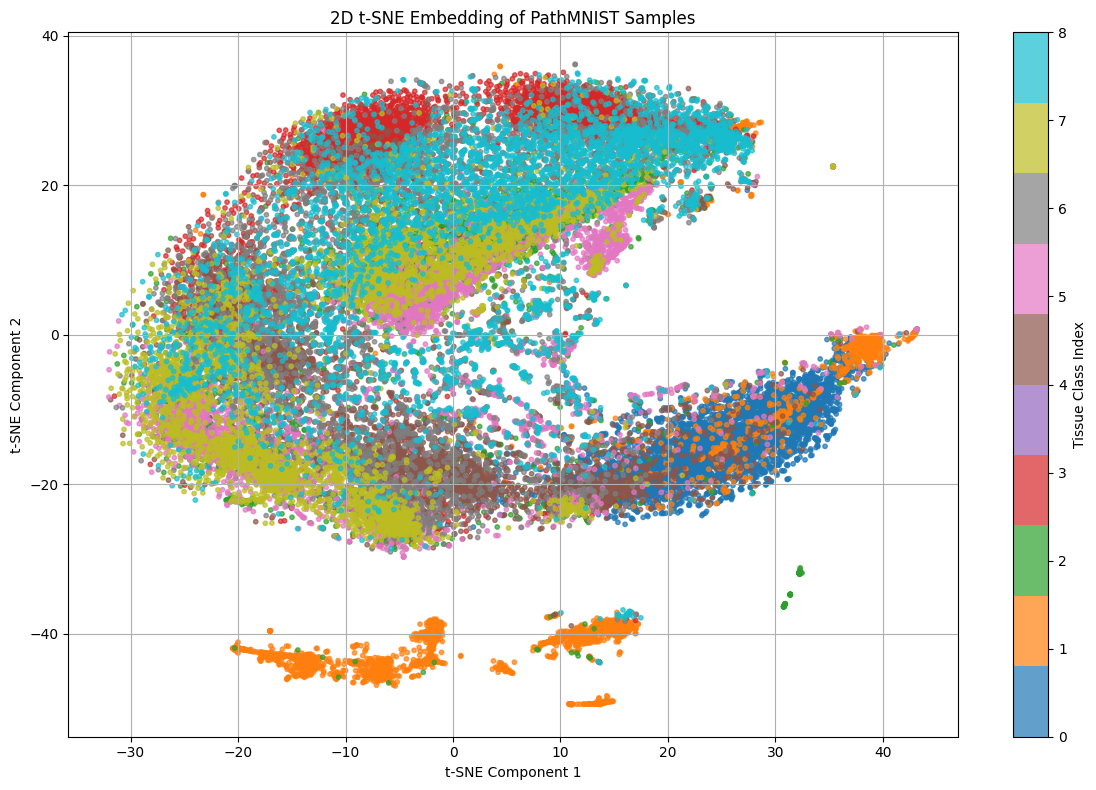

In [25]:
from sklearn.manifold import TSNE

# Prepare features and numeric labels
X = df_sampled.drop(columns=['label', 'MeanIntensity'], errors='ignore').values

# Map labels to numerical codes for colouring
label_map = {name: idx for idx, name in enumerate(df_sampled['label'].unique())}
y = df_sampled['label'].map(label_map).values

# Run t-SNE (this might take a few minutes for 40k samples)
print("⏳ Running t-SNE on pixel data... Please wait.")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=750, verbose=1)
X_embedded = tsne.fit_transform(X)

# Plot the 2D t-SNE embedding
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='tab10', s=10, alpha=0.7)

# Format plot
plt.title("2D t-SNE Embedding of PathMNIST Samples")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter, ticks=range(len(label_map)), label="Tissue Class Index")
plt.grid(True)
plt.tight_layout()
plt.show()


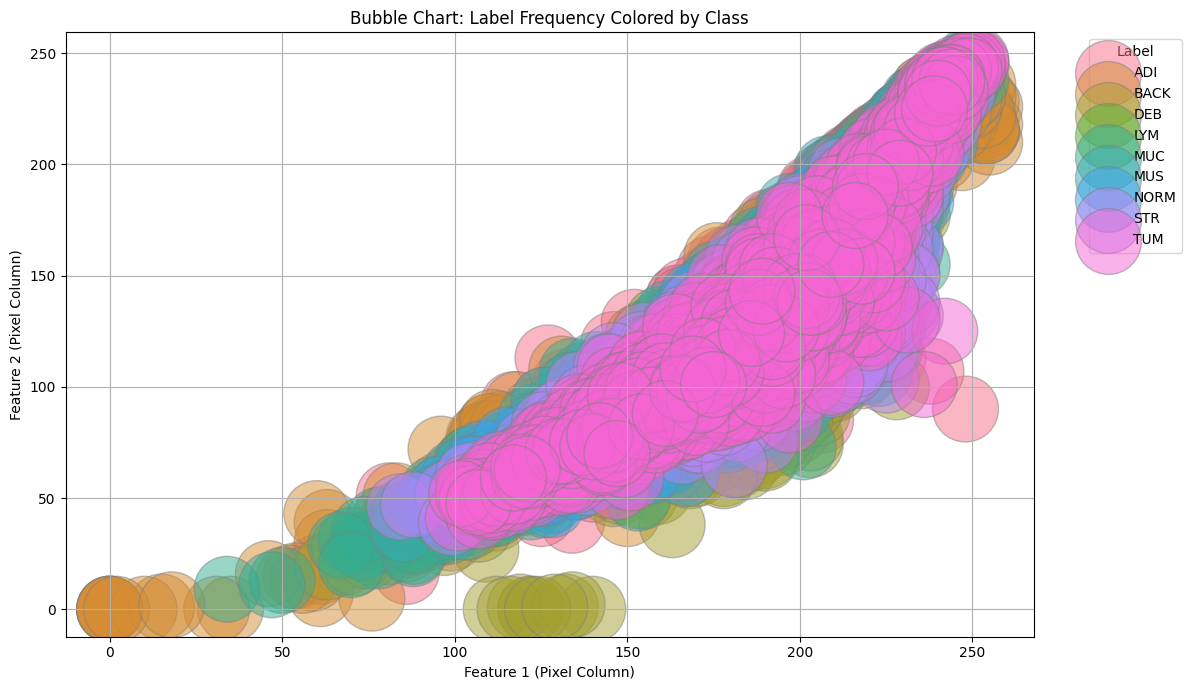

In [26]:
# Pick any two pixel columns (or use PCA/t-SNE coordinates instead)
x = df_sampled.iloc[:, 1]
y = df_sampled.iloc[:, 2]

# Create color palette for classes
unique_labels = df_sampled['label'].unique()
palette = dict(zip(unique_labels, sns.color_palette("husl", len(unique_labels))))

# Calculate bubble sizes based on frequency of each class
label_sizes = df_sampled['label'].map(df_sampled['label'].value_counts()) * 0.5

# Plot
plt.figure(figsize=(12, 7))
for label in unique_labels:
    subset = df_sampled[df_sampled['label'] == label]
    plt.scatter(
        subset.iloc[:, 1],  # x
        subset.iloc[:, 2],  # y
        s=label_sizes[subset.index],
        alpha=0.5,
        c=[palette[label]],
        label=label,
        edgecolors='gray'
    )

plt.xlabel("Feature 1 (Pixel Column)")
plt.ylabel("Feature 2 (Pixel Column)")
plt.title("Bubble Chart: Label Frequency Colored by Class")
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

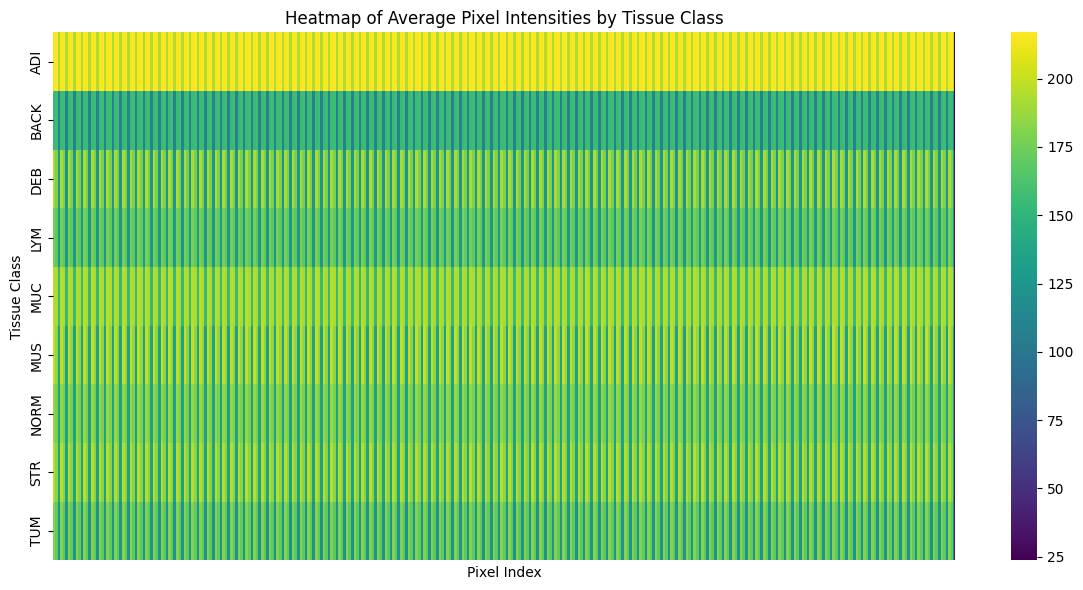

In [27]:
# Select only pixel columns (exclude label and MeanIntensity if present)
pixel_columns = df_sampled.columns.difference(['label', 'MeanIntensity'])

# Calculate average pixel intensity for each class
avg_by_class = df_sampled.groupby('label')[pixel_columns].mean()

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(avg_by_class, cmap="viridis", xticklabels=False)
plt.title("Heatmap of Average Pixel Intensities by Tissue Class")
plt.ylabel("Tissue Class")
plt.xlabel("Pixel Index")
plt.tight_layout()
plt.show()


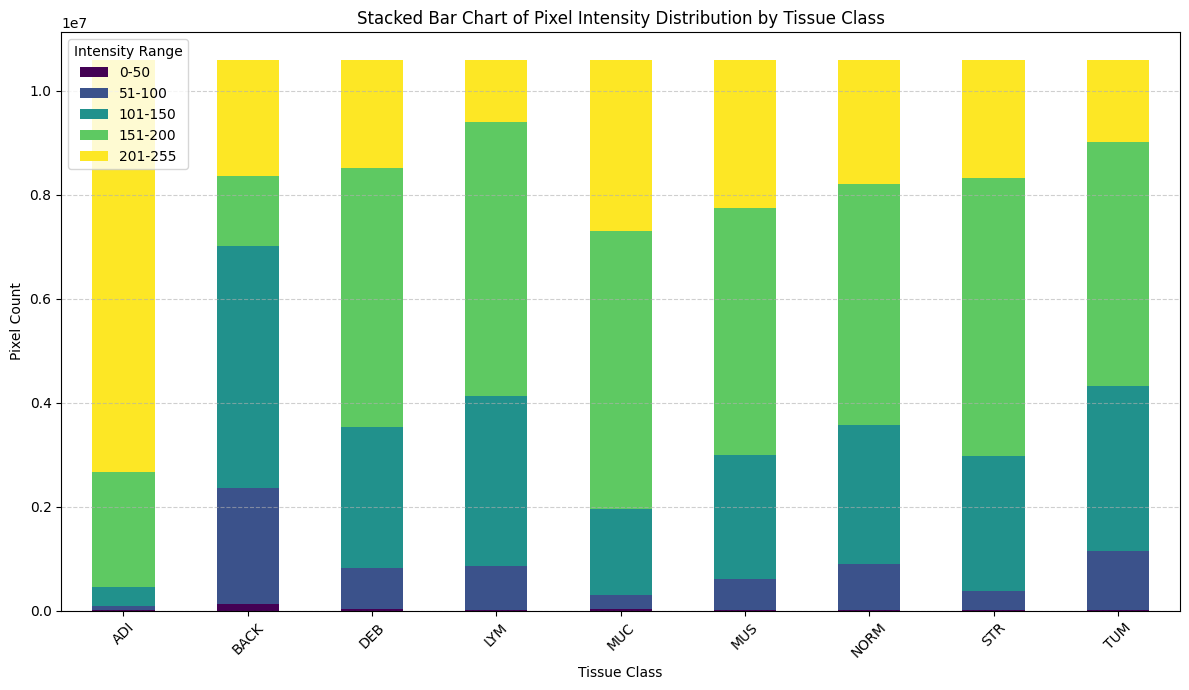

In [28]:
# Define pixel intensity bins and labels
bins = [0, 50, 100, 150, 200, 255]
bin_labels = ['0-50', '51-100', '101-150', '151-200', '201-255']

# Identify only pixel columns (exclude label and MeanIntensity if it exists)
pixel_columns = df_sampled.columns.difference(['label', 'MeanIntensity'])

# Create empty DataFrame for distribution
intensity_distribution = pd.DataFrame(0, index=df_sampled['label'].unique(), columns=bin_labels)

# Calculate binned pixel intensity counts per class
for label in df_sampled['label'].unique():
    class_pixels = df_sampled[df_sampled['label'] == label][pixel_columns].values.flatten()
    binned = pd.cut(class_pixels, bins=bins, labels=bin_labels, include_lowest=True)
    counts = binned.value_counts().sort_index()
    intensity_distribution.loc[label] = counts

# Convert to int and sort by class name for consistency
intensity_distribution = intensity_distribution.astype(int).sort_index()

# Plot stacked bar chart
intensity_distribution.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')
plt.title("Stacked Bar Chart of Pixel Intensity Distribution by Tissue Class")
plt.xlabel("Tissue Class")
plt.ylabel("Pixel Count")
plt.xticks(rotation=45)
plt.legend(title="Intensity Range")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

📊 Contingency Table:

group     A     B     C
label                  
ADI    1564  1473  1463
BACK   1466  1540  1494
DEB    1555  1455  1490
LYM    1489  1525  1486
MUC    1477  1525  1498
MUS    1473  1550  1477
NORM   1500  1463  1537
STR    1609  1394  1497
TUM    1469  1485  1546


<Figure size 1000x600 with 0 Axes>

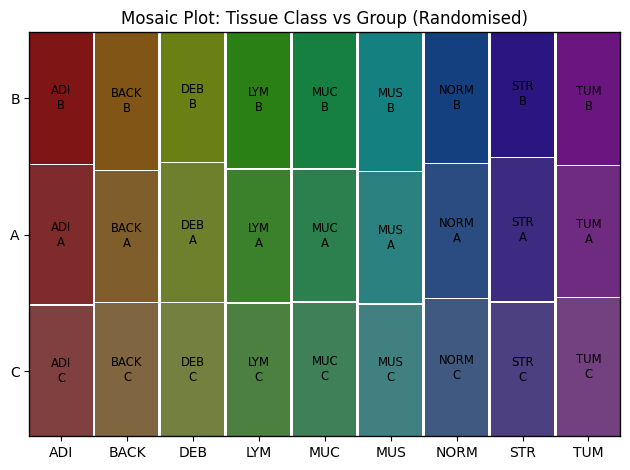

In [30]:
from statsmodels.graphics.mosaicplot import mosaic

# Create a dummy categorical column for demonstration
np.random.seed(42)  # for consistent results
df_sampled['group'] = np.random.choice(['A', 'B', 'C'], size=len(df_sampled))

# Generate contingency table
contingency = pd.crosstab(df_sampled['label'], df_sampled['group'])
print("📊 Contingency Table:\n")
print(contingency)

# Plot mosaic
plt.figure(figsize=(10, 6))
mosaic(df_sampled, ['label', 'group'])
plt.title("Mosaic Plot: Tissue Class vs Group (Randomised)")
plt.tight_layout()
plt.show()


In [12]:
from sklearn.model_selection import train_test_split

# X = pixel values only, y = label
X = df_sampled.drop(columns=['label', 'MeanIntensity'], errors='ignore')
y = df_sampled['label']

# First split: 90% train+val, 10% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# Second split: 70% train, 20% val (out of original 90%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=2/9, stratify=y_temp, random_state=42)

# Confirm sizes
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (28350, 2352), Val: (8100, 2352), Test: (4050, 2352)


In [13]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder instance
le = LabelEncoder()

# Fit the encoder on training labels and transform them into numeric form
y_train_enc = le.fit_transform(y_train)

# Use the same encoder to transform validation labels
y_val_enc = le.transform(y_val)

# Use the same encoder to transform test labels
y_test_enc = le.transform(y_test)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(max_iter=300, solver='saga')
lr.fit(X_train, y_train_enc)
y_pred_lr = lr.predict(X_val)

print("Logistic Regression Validation Report:")
print(classification_report(y_val_enc, y_pred_lr, target_names=le.classes_))


/Users/mac/Desktop/CW2/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Validation Report:
              precision    recall  f1-score   support

         ADI       0.72      0.86      0.78       900
        BACK       0.51      0.49      0.50       900
         DEB       0.19      0.25      0.21       900
         LYM       0.30      0.20      0.24       900
         MUC       0.41      0.40      0.40       900
         MUS       0.21      0.24      0.22       900
        NORM       0.20      0.19      0.20       900
         STR       0.19      0.20      0.19       900
         TUM       0.20      0.15      0.17       900

    accuracy                           0.33      8100
   macro avg       0.33      0.33      0.33      8100
weighted avg       0.33      0.33      0.33      8100



In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train_enc)
y_pred_rf = rf.predict(X_val)

print("Random Forest Validation Report:")
print(classification_report(y_val_enc, y_pred_rf, target_names=le.classes_))


Random Forest Validation Report:
              precision    recall  f1-score   support

         ADI       0.83      0.96      0.89       900
        BACK       0.99      0.89      0.94       900
         DEB       0.55      0.37      0.44       900
         LYM       0.66      0.77      0.71       900
         MUC       0.52      0.67      0.59       900
         MUS       0.68      0.57      0.62       900
        NORM       0.51      0.37      0.43       900
         STR       0.47      0.55      0.51       900
         TUM       0.48      0.53      0.51       900

    accuracy                           0.63      8100
   macro avg       0.63      0.63      0.63      8100
weighted avg       0.63      0.63      0.63      8100



In [15]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train_enc)
y_pred_knn = knn.predict(X_val)

print("KNN Validation Report:")
print(classification_report(y_val_enc, y_pred_knn, target_names=le.classes_))

KNN Validation Report:
              precision    recall  f1-score   support

         ADI       0.86      0.73      0.79       900
        BACK       0.19      0.95      0.32       900
         DEB       0.30      0.70      0.42       900
         LYM       0.20      0.00      0.01       900
         MUC       0.15      0.03      0.05       900
         MUS       0.48      0.15      0.23       900
        NORM       0.29      0.01      0.01       900
         STR       0.11      0.01      0.02       900
         TUM       0.59      0.10      0.17       900

    accuracy                           0.30      8100
   macro avg       0.35      0.30      0.22      8100
weighted avg       0.35      0.30      0.22      8100



In [18]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train_enc)
y_pred_xgb = xgb.predict(X_val)

print("XGBoost Validation Report:")
print(classification_report(y_val_enc, y_pred_xgb, target_names=le.classes_))

XGBoost Validation Report:
              precision    recall  f1-score   support

         ADI       0.91      0.95      0.93       900
        BACK       0.98      0.93      0.96       900
         DEB       0.63      0.49      0.55       900
         LYM       0.92      0.88      0.90       900
         MUC       0.67      0.75      0.71       900
         MUS       0.74      0.66      0.70       900
        NORM       0.60      0.62      0.61       900
         STR       0.56      0.61      0.58       900
         TUM       0.66      0.75      0.70       900

    accuracy                           0.74      8100
   macro avg       0.74      0.74      0.74      8100
weighted avg       0.74      0.74      0.74      8100

